# Transformer Encoder for Tweet Hatespeech Classification

Implementation adapted from <a href="https://towardsdatascience.com/text-classification-with-transformer-encoders-1dcaa50dabae"> Ruben Winastwan's model</a> for classifying emails as spam or not spam.

The transformer architecture as described in "Attention is All You Need" (Vaswani et al.) are used for text generation or translation tasks, and use both an encoder and decoder. 

The encoder portion of the architecture can be used by itself for classification tasks. This implementation uses this idea to classify text as containing hatespeech/offensive language or not.

### Import Libraries, Load the dataset

In [331]:
import math
import torch
import torch.nn as nn
import torchtext
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from tqdm import tqdm
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [332]:
DATA_PATH = "data/labeled_data.csv"

full_tweets_df = pd.read_csv(DATA_PATH)
full_tweets_df=full_tweets_df[["class","tweet"]]

### CLASS 1 : Contains no hatespeech  language or hatespeech
### CLASS 0 : Contains offensive language / hatespeech
full_tweets_df["class"] = full_tweets_df["class"].replace({2: 1, 0: 0, 1: 1})

np.random.seed(42)

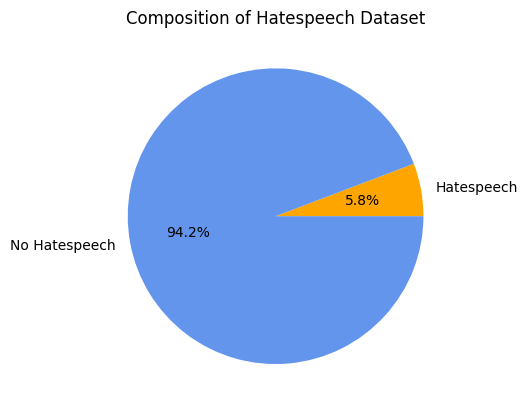

In [333]:
labels = 'Hatespeech', 'No Hatespeech'


sizes = [full_tweets_df['class'].value_counts()[0], full_tweets_df['class'].value_counts()[1]]

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels,autopct='%1.1f%%',colors=['orange', 'cornflowerblue'])
ax.set_title("Composition of Hatespeech Dataset")
plt.show()

## Undersampling

For our dataset, only about 6% of all entries fall into the hatespeech category. This is not great for us, because transformer models trained on this dataset never train and always label tweets as not containing hatespeech. In order to counteract this, we employ a method of undersampling. We randomly delete records from the "No Hatespeech" category. The goal is to increase the slice that the hatespeech tweets occupy, so that at least 10% of all the tweets are hatespeech tweets. This way, the model can actually train.

<a href="https://discuss.huggingface.co/t/how-can-i-use-class-weights-when-training/1067/9">source 1<a>

<a href="https://discuss.huggingface.co/t/how-to-give-equal-importance-of-all-labels-while-dealing-with-unbalanced-samples/14174"> source 2 </a>

class
1    23353
0     1430
Name: count, dtype: int64
class
1    13440
0     1430
Name: count, dtype: int64


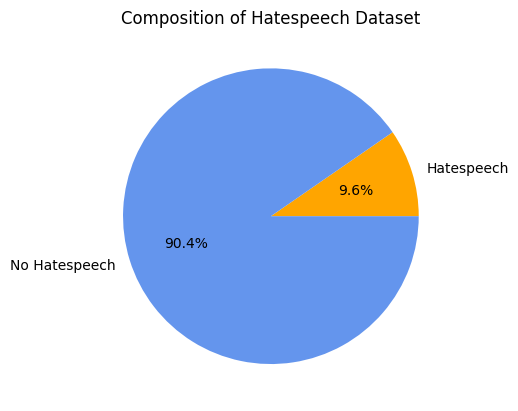

In [334]:
import random
# Calculate the number of rows for each class
class_counts = full_tweets_df['class'].value_counts()

print(class_counts)

total = class_counts[0] + class_counts[1]

difference = int(total*0.4)

# Identify the indices of the rows belonging to the majority class
majority_indices = full_tweets_df[full_tweets_df['class'] == 1].index.tolist()

# Randomly select indices from the majority indices to remove
indices_to_remove = random.sample(majority_indices, difference)

# Remove the selected indices from the DataFrame
tweets_df = full_tweets_df.drop(indices_to_remove)

labels = 'Hatespeech', 'No Hatespeech'


sizes = [tweets_df['class'].value_counts()[0], tweets_df['class'].value_counts()[1]]

class_counts = tweets_df['class'].value_counts()

print(class_counts)

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels,autopct='%1.1f%%',colors=['orange', 'cornflowerblue'])
ax.set_title("Composition of Hatespeech Dataset")
plt.show()

## Investigating How Accurate Filtering By Insults is

Why do we need a machine learning model to look for hatespeech and offensive language?
Here I will try the common strategy of simply flagging words known to be offensive by using a dataset of offensive words found on this github repository : 

In [335]:
import requests
import csv

CSV_URL="https://raw.githubusercontent.com/surge-ai/profanity/main/profanity_en.csv"

with requests.Session() as s:
    download = s.get(CSV_URL)

    decoded_content = download.content.decode('utf-8')

    cr = csv.reader(decoded_content.splitlines(), delimiter=',')
    my_list = list(cr)
insults_df=pd.DataFrame(my_list)
insults_df.columns = insults_df.iloc[0]
insults_df=insults_df[["text","canonical_form_1","category_1","severity_description"]]

tweets_df['tweet'] = tweets_df['tweet'].str.lower()
insults_df['text'] = insults_df['text'].str.lower()

severe_insults_df = insults_df[(insults_df["severity_description"] == "Severe")];

In [336]:
tweets_df['tweet'] = tweets_df['tweet'].str.lower()
insults_df['text'] = insults_df['text'].str.lower()

def find_first_insult(tweet, df):
    words = tweet.split(" ")
    # print(tweet)
    insults = []
    for word in words:
        word = word.strip()
        if df['text'].isin([word]).any():
            insults.append(word)
    if len(insults) > 0:
        return insults
    else:
        return None
    
def contains_insult(tweet, df):
    words = tweet.split(" ")
    for word in words:
        word = word.strip()
        if df['text'].isin([word]).any():
            return True
    return False


# find insults in each tweet
tweets_df['contains_insult'] = tweets_df['tweet'].apply(lambda x: find_first_insult(x,insults_df))
tweets_df['contains_severe_insult'] = tweets_df['tweet'].apply(lambda x: contains_insult(x,severe_insults_df))

# Filter tweets containing insults from the insult dataset
hatespeech_tweets = tweets_df[tweets_df['class'] == 0]
no_hatespeech_tweets = tweets_df[tweets_df['class'] == 1];

In [337]:

insult_hatespeech_categories = {}
insult_no_hatespeech_categories = {}

def category_of_insults(insult_list, df, hatespeech = True):
    global insult_hatespeech_categories
    global insult_no_hatespeech_categories
    categories = []
    if insult_list == None:
        return None
    for insult in insult_list:
        if not df['text'].isin([insult]).any():
            continue
        row = df[df['text'].str.contains(insult)].iloc[0]['category_1']
        category = row.strip()
        if category == 'category_1':
            continue
        categories.append(category)
        if hatespeech:
            if category in insult_hatespeech_categories:
                insult_hatespeech_categories[category] += 1
            else:
                insult_hatespeech_categories[category] = 1
        else:
            if category in insult_no_hatespeech_categories:
                insult_no_hatespeech_categories[category] += 1
            else:
                insult_no_hatespeech_categories[category] = 1
    if len(categories) == 0:
        categories = None
    return categories

hatespeech_tweets['category'] = hatespeech_tweets['contains_insult'].apply(lambda x: category_of_insults(x,severe_insults_df, True))
no_hatespeech_tweets['category'] = no_hatespeech_tweets['contains_insult'].apply(lambda x: category_of_insults(x,severe_insults_df, False));


/var/folders/56/lnrgwj295yq6l00hqdbfzfmr0000gn/T/ipykernel_43002/1651706291.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hatespeech_tweets['category'] = hatespeech_tweets['contains_insult'].apply(lambda x: category_of_insults(x,severe_insults_df, True))
/var/folders/56/lnrgwj295yq6l00hqdbfzfmr0000gn/T/ipykernel_43002/1651706291.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_hatespeech_tweets['category'] = no_hatespeech_tweets['contains_insult'].apply(lambda x: category_of_insults(x,severe_i

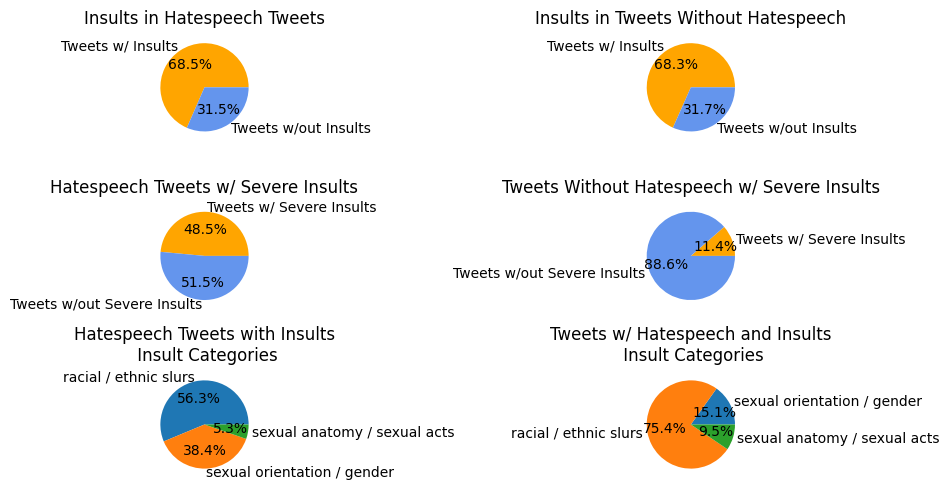

In [338]:
# Count the number of tweets with and without insults for hatespeech and no_hatespeech tweets
no_insults_hatespeech_count = hatespeech_tweets['contains_insult'].isna().sum()
no_insults_no_hatespeech_count = no_hatespeech_tweets['contains_insult'].isna().sum()

# Count the number of tweets without severe insults for hatespeech and no_hatespeech tweets
severe_hatespeech_count = (hatespeech_tweets['contains_severe_insult'] == True).sum()
no_severe_hatespeech_count = (hatespeech_tweets['contains_severe_insult'] == False).sum()

severe_no_hatespeech_count = (no_hatespeech_tweets['contains_severe_insult'] == True).sum()
no_severe_no_hatespeech_count = (no_hatespeech_tweets['contains_severe_insult'] == False).sum()

# Plotting pie charts
fig, axs = plt.subplots(3, 2, figsize=(10, 5))

# Pie chart for offensive tweets
axs[0][0].pie([hatespeech_tweets['contains_insult'].size - no_insults_hatespeech_count, no_insults_hatespeech_count], 
       labels=['Tweets w/ Insults', 'Tweets w/out Insults'],autopct='%1.1f%%',colors=['orange', 'cornflowerblue'])
axs[0][0].set_title('Insults in Hatespeech Tweets')

# Pie chart for no_hatespeech tweets
axs[0][1].pie([no_hatespeech_tweets['contains_insult'].size - no_insults_no_hatespeech_count, no_insults_no_hatespeech_count], 
       labels=['Tweets w/ Insults', 'Tweets w/out Insults'],autopct='%1.1f%%',colors=['orange', 'cornflowerblue'])
axs[0][1].set_title('Insults in Tweets Without Hatespeech')

axs[1][0].pie([severe_hatespeech_count, no_severe_hatespeech_count],
              labels=['Tweets w/ Severe Insults','Tweets w/out Severe Insults'],autopct='%1.1f%%',colors=['orange', 'cornflowerblue'])
axs[1][0].set_title('Hatespeech Tweets w/ Severe Insults')

axs[1][1].pie([severe_no_hatespeech_count, no_severe_no_hatespeech_count],
              labels=['Tweets w/ Severe Insults','Tweets w/out Severe Insults'],autopct='%1.1f%%',colors=['orange', 'cornflowerblue'])
axs[1][1].set_title('Tweets Without Hatespeech w/ Severe Insults')

axs[2][0].pie([x for x in insult_hatespeech_categories.values()],
              labels=[x for x in insult_hatespeech_categories.keys()], autopct='%1.1f%%')
axs[2][0].set_title('Hatespeech Tweets with Insults\n Insult Categories')

axs[2][1].pie([x for x in insult_no_hatespeech_categories.values()],
              labels=[x for x in insult_no_hatespeech_categories.keys()], autopct='%1.1f%%')
axs[2][1].set_title('Tweets w/ Hatespeech and Insults\n Insult Categories')

plt.tight_layout()
plt.show()

# Create pie chart

# Extract category labels and frequencies
# insult_hatespeech_categories
# insult_no_hatespeech_categories
categories_hatespeech_insults = list(insult_hatespeech_categories.keys())
frequencies_hatespeech_insults = list(insult_hatespeech_categories.values())

categories_no_hatespeech_insults = list(insult_no_hatespeech_categories.keys())
frequencies_no_hatespeech_insults = list(insult_no_hatespeech_categories.values())


### Flagging Occurances of Specific Slurs As a Strategy for Labeling Hatespeech

Simply flagging for offensive words or swears in tweets, ignoring the context they exist in, is a possible approach that we can take in order to identify tweets as containing hatespeech or not. But this approach may not be sufficient to accurately flag tweets. 

The same proportion of hatespeech tweets and normal tweets contain insults / offensive language, to a tenth of a percentage. This shows that by simply flagging tweets as hatespeech for containing insults in general, we would mislabel 31.6% of normal tweets as hatespeech, and mislabel 31.5% of hatespeech tweets as not containing hatespeech. We would mislabel normal tweets and hatespeech tweets at exactly the same rate.

For tweets that contain insults or strong language, both hatespeech and not hatespeech tweets have similar makeups in terms of the category of the insult. All three have racial / ethnic slurs, sexual orientation / gender, and sexual anatomy / sexual acts as their top three categories of insult, in that order. Although, hatespeech tweets that contain insults do contain slightly less racial/ethnic slurs than not hatespeech tweets that contain insults.

Although hatespeech tweets disproportionately contain slurs labeled as "severe" in comparison to normal tweets, almost half of all hatespeech tweets do not contain "severe" language. Additionally, 11.4% of normal tweets also contain this "severe" language. Flagging all severe language would surely result in a large proportion of normal tweets, not containing hatespeech, in being flagged as hatespeech. This could become problematic, especially if these specific terms are being used in the context of social justice. If we label all tweets containing severe language as hatespeech, over half of all hatespeech tweets will not be labeled correctly.

### Machine Learning May Improve Our Odds

We believe that we can improve upon this strategy of flagging hatespeech by, instead of searching for particular phrases and words, utilizing machine learning algorithms to label text as containing hatespeech or not. This would allow for models to take into consideration the context surrounding the usage of the terms and insults, and hopefully allow for a more effective algorithm.

In [339]:
import re

print(tweets_df["tweet"].head(30))

# Function to remove HTML numerical representations
def remove_html_numerical(text):
    # pattern = r'(&#\d+;)|((RT)?@[\w_0-9]+:?)|(https?://[^\s"]*)|(^!+( rt)?)|(^ (rt))|(^\s*")|("$)'
    pattern = r'(&#\d+;)|((RT)?@[\w_0-9]+:?)|(https?://[^\s"]*)'
    return re.sub(pattern, '', text)

tweets_df['tweet'] = tweets_df['tweet'].apply(lambda x: remove_html_numerical(x))

df_train, df_test = train_test_split(tweets_df,test_size=0.2)


3     !!!!!!!!! rt @c_g_anderson: @viva_based she lo...
4     !!!!!!!!!!!!! rt @shenikaroberts: the shit you...
6     !!!!!!"@__brighterdays: i can not just sit up ...
7     !!!!&#8220;@selfiequeenbri: cause i'm tired of...
9     " @rhythmixx_ :hobbies include: fighting maria...
10    " keeks is a bitch she curves everyone " lol i...
11                   " murda gang bitch its gang land "
13        " bad bitches is the only thing that i like "
14                              " bitch get up off me "
15                      " bitch nigga miss me with it "
16                               " bitch plz whatever "
19                   " black bottle &amp; a bad bitch "
20                 " broke bitch cant tell me nothing "
21                      " cancel that bitch like nino "
22              " cant you see these hoes wont change "
24    " got ya bitch tip toeing on my hardwood floor...
25       " her pussy lips like heaven doors " &#128524;
33       " if you're toes ain't done you pussy s

In [340]:

label2id = {'Hatespeech':0, 'No Hatespeech':1}
id2label = {0: 'Hatespeech', 1: 'No Hatespeech'}


## Tokenizer

Splits the text into tokens. This is a word-level tokenizer, each token represents one word.

In [341]:
tokenizer = get_tokenizer('basic_english')

Map tokens, i.e. words, to integer representation according to the vocabulary. Each word in dataset gets it's own unique integer mapping. <pad\> will be used to make sequences all the same length later on. <unk\>, the unknown keyword will represent words not in the vocabulary.

In [342]:
# Initialize training data iterator
class TextIter(torch.utils.data.Dataset):

  def __init__(self, input_data):
      self.text = input_data['tweet'].values.tolist()
  def __len__(self):
      return len(self.text)
  def __getitem__(self, idx):
      return self.text[idx]

# Build vocabulary
def yield_tokens(data_iter):
    for text in data_iter:
        yield tokenizer(text)

data_iter = TextIter(df_train)
vocab = build_vocab_from_iterator(yield_tokens(data_iter), specials=["<pad>", "<unk>"])
vocab.set_default_index(vocab["<unk>"])
print(vocab.get_stoi())


{'~~': 14688, '~&gt': 14686, '|_': 14684, 'zzzzzz': 14682, 'zrgrizz': 14679, 'zoomed': 14677, 'zoom': 14676, 'zoneing': 14674, 'zombies': 14673, 'zombie': 14672, 'zlatan': 14669, 'zip-line': 14667, 'zion': 14666, 'zima': 14665, 'zim': 14664, 'zijn': 14663, 'zigeuner': 14661, 'zich': 14660, 'zertec': 14658, 'zerah': 14657, 'zei': 14655, 'zappa': 14654, 'zal': 14653, 'zak': 14652, 'zac': 14650, 'yyyyyeelllloooowwwwww': 14649, 'yusa': 14647, 'yun': 14645, 'yuhh': 14644, 'yuck': 14643, 'youza': 14642, 'youz': 14641, 'youve': 14640, 'youuuuu': 14639, 'youtube/vine/ig': 14637, 'youth': 14636, 'yourselves': 14635, 'younow': 14634, 'you&gt': 14632, 'yoooooouuuu': 14630, 'yoooooooooooooo': 14629, 'yoo': 14627, 'yoi': 14624, 'yoh': 14623, 'yocomo': 14621, 'yoburger': 14620, 'yob': 14619, 'ym': 14618, 'yll': 14617, 'yhe': 14615, 'yessssss': 14612, 'yello': 14608, 'yeezy': 14605, 'yearbook': 14601, 'yeah&gt': 14598, 'yeaaaaahhhh': 14597, 'ye': 14596, 'yassssssssss': 14592, 'yassssss': 14591, 'yard

## Embedding Layer

In [343]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab_size):
        super(Embeddings, self).__init__()
        self.emb = nn.Embedding(vocab_size, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.emb(x) * math.sqrt(self.d_model)


In [344]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, vocab_size=5000, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(vocab_size, d_model)
        position = torch.arange(0, vocab_size, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float()
            * (-math.log(10000.0) / d_model)
        )
  
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[:, : x.size(1), :]
        return self.dropout(x)
    

In [345]:
class SingleHeadAttention(nn.Module):
    def __init__(self, d_model, d_head_size):
        super().__init__()
        self.lin_key = nn.Linear(d_model, d_head_size, bias=False)
        self.lin_query = nn.Linear(d_model, d_head_size, bias=False)
        self.lin_value = nn.Linear(d_model, d_head_size, bias=False)
        self.d_model = d_model

    def forward(self, x):
        query = self.lin_query(x)
        key = self.lin_key(x)
        value = self.lin_value(x)

        scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(self.d_model)
        p_attn = scores.softmax(dim=-1)
        x = torch.matmul(p_attn, value)

        return x
    
class MultiHeadAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        super().__init__()
        assert d_model % h == 0
        d_k = d_model // h
        self.multi_head = nn.ModuleList([SingleHeadAttention(d_model, d_k) for _ in range(h)])
        self.lin_agg = nn.Linear(d_model, d_model)

    def forward(self, x):
        x = torch.cat([head(x) for head in self.multi_head], dim=-1)
        return self.lin_agg(x)


In [346]:
class LayerNorm(nn.Module):
    def __init__(self, d_model, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(d_model))
        self.b_2 = nn.Parameter(torch.zeros(d_model))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

class ResidualConnection(nn.Module):
    def __init__(self, d_model, dropout=0.1):
        super().__init__()
        self.norm = LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x1, x2):
        return self.dropout(self.norm(x1 + x2))


In [347]:
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(self.w_1(x).relu()))



## Single Encoder

In [348]:
class SingleEncoder(nn.Module):
    def __init__(self, d_model, self_attn, feed_forward, dropout):
        super().__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.res_1 = ResidualConnection(d_model, dropout)
        self.res_2 = ResidualConnection(d_model, dropout)

        self.d_model = d_model

    def forward(self, x):
        x_attn = self.self_attn(x)
        x_res_1 = self.res_1(x, x_attn)
        x_ff = self.feed_forward(x_res_1)
        x_res_2 = self.res_2(x_res_1, x_ff)

        return x_res_2

## BERT-base model (12 stacks of Transformer encoders)

In [349]:
class EncoderBlocks(nn.Module):
    def __init__(self, layer, N):
        super().__init__()
        self.layers = nn.ModuleList([layer for _ in range(N)])
        self.norm = LayerNorm(layer.d_model)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return self.norm(x)

## Defining Our Model

In [350]:
class TransformerEncoderModel(nn.Module):
    def __init__(self, vocab_size, d_model, nhead, d_ff, N,
                dropout=0.1):
        super().__init__()
        assert d_model % nhead == 0, "nheads must divide evenly into d_model"

        self.emb = Embeddings(d_model, vocab_size)
        self.pos_encoder = PositionalEncoding(d_model=d_model, vocab_size=vocab_size)

        attn = MultiHeadAttention(nhead, d_model)
        ff = FeedForward(d_model, d_ff, dropout)
        self.transformer_encoder = EncoderBlocks(SingleEncoder(d_model, attn, ff, dropout), N)
        self.classifier = nn.Linear(d_model, 2)
        self.d_model = d_model

    def forward(self, x):
        x = self.emb(x) * math.sqrt(self.d_model)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)
        x = self.classifier(x)
        return x

In [351]:
class TextDataset(torch.utils.data.Dataset):

  def __init__(self, input_data):        
      self.text = input_data['tweet'].values.tolist()
      self.label = input_data['class'].values.tolist()

  def __len__(self):
      return len(self.label)
    
  def get_sequence_token(self, idx):
      sequence = [vocab[word] for word in tokenizer(self.text[idx])]
      len_seq = len(sequence)
      return sequence, len_seq
  
  def get_labels(self, idx):
      return self.label[idx]

  def __getitem__(self, idx):
      sequence, len_seq = self.get_sequence_token(idx)
      label = self.get_labels(idx)
      return sequence, label, len_seq

def collate_fn(batch):
  
    sequences, labels, lengths = zip(*batch)
    max_len = max(lengths)
    
    for i in range(len(batch)):
        if len(sequences[i]) != max_len:
          for j in range(len(sequences[i]),max_len):
            sequences[i].append(0)

    return torch.tensor(sequences, dtype=torch.long), torch.tensor(labels, dtype=torch.long)

## Training Loop

In [361]:
def train(model, dataset, epochs, lr, bs):

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam((p for p in model.parameters() 
      if p.requires_grad), lr=lr)
    train_dataset = TextDataset(dataset)
    # Ran into a
    train_dataloader = DataLoader(train_dataset, num_workers=0, batch_size=bs, collate_fn=collate_fn, shuffle=True)
    train_accuracies = []
    train_losses = []
    # Training loop
    for epoch in range(epochs):
        total_loss_train = 0
        total_acc_train = 0   
        for train_sequence, train_label in tqdm(train_dataloader):
            
            # Model prediction
            predictions = model(train_sequence.to(device))
            labels = train_label.to(device)
            loss = criterion(predictions, labels)

            # Calculate accuracy and loss per batch
            correct = predictions.argmax(axis=1) == labels
            acc = correct.sum().item() / correct.size(0)
            total_acc_train += correct.sum().item()
            total_loss_train += loss.item()

            # Backprop
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            optimizer.step()
        train_accuracies.append(total_acc_train)
        train_losses.append(total_loss_train)
        print(f'Epochs: {epoch + 1} | Loss: {total_loss_train / len(train_dataset): .3f} | Accuracy: {total_acc_train / len(train_dataset): .3f}')
    return train_losses, train_accuracies
  

In [384]:
model = TransformerEncoderModel(len(vocab), d_model=300, nhead=4, d_ff=50, 
                                    N=6, dropout=0.1).to(device)

epochs = 5
lr = 1e-4
batch_size = 4

train(model, df_train, epochs, lr, batch_size)

  0%|          | 2/2974 [00:00<03:56, 12.55it/s]

100%|██████████| 2974/2974 [02:02<00:00, 24.35it/s]


Epochs: 1 | Loss:  0.101 | Accuracy:  0.905


100%|██████████| 2974/2974 [01:54<00:00, 26.04it/s]


Epochs: 2 | Loss:  0.097 | Accuracy:  0.905


100%|██████████| 2974/2974 [01:54<00:00, 25.92it/s]


Epochs: 3 | Loss:  0.094 | Accuracy:  0.904


100%|██████████| 2974/2974 [01:56<00:00, 25.56it/s]


Epochs: 4 | Loss:  0.086 | Accuracy:  0.910


100%|██████████| 2974/2974 [01:55<00:00, 25.85it/s]

Epochs: 5 | Loss:  0.084 | Accuracy:  0.911


([1200.3819270029198,
  1154.6344552421942,
  1118.5501854893519,
  1021.1553017694969,
  997.6617312394083],
 [10770, 10762, 10751, 10826, 10832])

In [379]:
def predict(your_model, text):
  sequence = torch.tensor([vocab[word] for word in tokenizer(text)], dtype=torch.long).unsqueeze(0)
  output = your_model(sequence.to(device))
  prediction = output.argmax(axis=1).item()

  return prediction

Accuracy: 0.8971082716879624


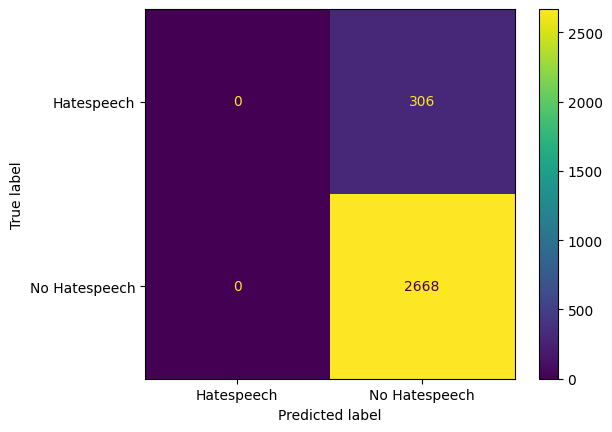

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
correct = 0
incorrect = 0
predictions = []
for i in range(len(df_test)):

    text =  df_test['tweet'].iloc[i] #balanced_df['tweet'].values.tolist()[idx]
    gt = df_test['class'].iloc[i] #balanced_df['class'].values.tolist()[idx]
    prediction = predict(model, df_test['tweet'].iloc[i])
    predictions.append(prediction)

    # print(f'Text: {text}')
    # print(f'Ground Truth: {gt}')
    # print(f'Prediction: {prediction}')

    if prediction == gt:
        correct += 1
    else:
        incorrect += 1

print("Accuracy:",correct/ (incorrect + correct))
cm = confusion_matrix(df_test['class'], predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=["Hatespeech","No Hatespeech"])
disp.plot()
plt.show()


In [380]:
full_tweets_df['tweet'] = full_tweets_df['tweet'].apply(lambda x: remove_html_numerical(x))

def evaluate(test_data, your_model):
    correct = 0
    incorrect = 0
    predictions = []
    for i in range(len(test_data)):
        gt = test_data['class'].iloc[i] #balanced_df['class'].values.tolist()[idx]
        prediction = predict(your_model, test_data['tweet'].iloc[i])
        predictions.append(prediction)

        # print(f'Text: {text}')
        # print(f'Ground Truth: {gt}')
        # print(f'Prediction: {prediction}')

        if prediction == gt:
            correct += 1
        else:
            incorrect += 1


    # print("Accuracy:",correct/ (incorrect + correct))
    # cm = confusion_matrix(test_data['class'], predictions)
    # disp = ConfusionMatrixDisplay(confusion_matrix=cm,
    #                             display_labels=["Hatespeech","No Hatespeech"])
    # disp.plot()
    # plt.show()
    return correct/(incorrect+correct)

# evaluate(full_tweets_df, model)

## Cross Validation

In [382]:
from sklearn.model_selection import KFold, cross_val_score 

k_folds = KFold(n_splits=5, shuffle=True)

fold_no = 1
for train1, test in k_folds.split(tweets_df['tweet'],tweets_df['class']):
    model = TransformerEncoderModel(len(vocab), d_model=300, nhead=4, d_ff=50, 
                                    N=6, dropout=0.1).to(device)

    train_input = tweets_df.iloc[train1]
    train_classes = tweets_df['class'].iloc[train1]

    print("~~~~~~~~~~~~~~~~~~~~~~~~~~")
    print(f"Training for fold {fold_no}")
    epochs = 5
    lr = 1e-4
    batch_size = 4
    fold_accuracies, fold_losses = train(model, train_input, epochs, lr, batch_size)

    print(f'Fold training loss {fold_losses[-1]}, training accuracy {fold_accuracies[-1]}')
    testing_accuracy = evaluate(tweets_df.iloc[test], model)
    print(f'Fold Testing Accuracy {testing_accuracy}')
    fold_no = fold_no + 1


~~~~~~~~~~~~~~~~~~~~~~~~~~
Training for fold 1


  0%|          | 3/2974 [00:00<02:00, 24.61it/s]

100%|██████████| 2974/2974 [02:04<00:00, 23.85it/s]


Epochs: 1 | Loss:  0.099 | Accuracy:  0.901


100%|██████████| 2974/2974 [15:57<00:00,  3.11it/s]   


Epochs: 2 | Loss:  0.094 | Accuracy:  0.905


100%|██████████| 2974/2974 [07:35<00:00,  6.53it/s]  


Epochs: 3 | Loss:  0.088 | Accuracy:  0.907


100%|██████████| 2974/2974 [02:05<00:00, 23.62it/s]  


Epochs: 4 | Loss:  0.083 | Accuracy:  0.910


100%|██████████| 2974/2974 [14:50<00:00,  3.34it/s]  


Epochs: 5 | Loss:  0.083 | Accuracy:  0.911
Fold training loss 10840, training accuracy 989.929153478588
Fold Testing Accuracy 0.8981170141223941
~~~~~~~~~~~~~~~~~~~~~~~~~~
Training for fold 2


100%|██████████| 2974/2974 [01:46<00:00, 27.93it/s]


Epochs: 1 | Loss:  0.099 | Accuracy:  0.904


100%|██████████| 2974/2974 [01:41<00:00, 29.24it/s]


Epochs: 2 | Loss:  0.097 | Accuracy:  0.904


100%|██████████| 2974/2974 [01:41<00:00, 29.23it/s]


Epochs: 3 | Loss:  0.094 | Accuracy:  0.904


100%|██████████| 2974/2974 [01:47<00:00, 27.73it/s]


Epochs: 4 | Loss:  0.097 | Accuracy:  0.903


100%|██████████| 2974/2974 [01:42<00:00, 28.92it/s]


Epochs: 5 | Loss:  0.099 | Accuracy:  0.904
Fold training loss 10751, training accuracy 1180.2606364651583
Fold Testing Accuracy 0.9048419636852724
~~~~~~~~~~~~~~~~~~~~~~~~~~
Training for fold 3


100%|██████████| 2974/2974 [01:42<00:00, 29.09it/s]


Epochs: 1 | Loss:  0.101 | Accuracy:  0.903


100%|██████████| 2974/2974 [01:38<00:00, 30.26it/s]


Epochs: 2 | Loss:  0.092 | Accuracy:  0.905


100%|██████████| 2974/2974 [01:44<00:00, 28.49it/s]


Epochs: 3 | Loss:  0.089 | Accuracy:  0.906


100%|██████████| 2974/2974 [01:44<00:00, 28.34it/s]


Epochs: 4 | Loss:  0.086 | Accuracy:  0.909


100%|██████████| 2974/2974 [01:44<00:00, 28.33it/s]


Epochs: 5 | Loss:  0.081 | Accuracy:  0.913
Fold training loss 10863, training accuracy 960.5317622483708
Fold Testing Accuracy 0.9021519838601211
~~~~~~~~~~~~~~~~~~~~~~~~~~
Training for fold 4


100%|██████████| 2974/2974 [01:59<00:00, 24.94it/s]


Epochs: 1 | Loss:  0.097 | Accuracy:  0.903


100%|██████████| 2974/2974 [01:38<00:00, 30.08it/s]


Epochs: 2 | Loss:  0.092 | Accuracy:  0.905


100%|██████████| 2974/2974 [02:51<00:00, 17.30it/s] 


Epochs: 3 | Loss:  0.086 | Accuracy:  0.908


100%|██████████| 2974/2974 [01:52<00:00, 26.42it/s]


Epochs: 4 | Loss:  0.084 | Accuracy:  0.909


100%|██████████| 2974/2974 [01:45<00:00, 28.12it/s]


Epochs: 5 | Loss:  0.083 | Accuracy:  0.911
Fold training loss 10837, training accuracy 990.6882418810856
Fold Testing Accuracy 0.9092131809011432
~~~~~~~~~~~~~~~~~~~~~~~~~~
Training for fold 5


100%|██████████| 2974/2974 [01:52<00:00, 26.44it/s]


Epochs: 1 | Loss:  0.098 | Accuracy:  0.904


100%|██████████| 2974/2974 [02:28<00:00, 19.97it/s]  


Epochs: 2 | Loss:  0.092 | Accuracy:  0.905


100%|██████████| 2974/2974 [01:54<00:00, 25.91it/s]


Epochs: 3 | Loss:  0.088 | Accuracy:  0.909


100%|██████████| 2974/2974 [01:53<00:00, 26.18it/s]


Epochs: 4 | Loss:  0.083 | Accuracy:  0.910


100%|██████████| 2974/2974 [01:55<00:00, 25.69it/s]


Epochs: 5 | Loss:  0.082 | Accuracy:  0.913
Fold training loss 10863, training accuracy 972.818870869698
Fold Testing Accuracy 0.8967720242098184


In [383]:
fold_average_training_loss = (0.083 + 0.099 + 0.081 + 0.083 + 0.082) / 5
fold_average_training_accuracy = (0.911 + 0.904 + 0.913 + 0.911 + 0.913) / 5
fold_average_testing_accuracy = (0.8981170141223941 + 0.9048419636852724 + 0.9021519838601211 + 0.9092131809011432 + 0.8967720242098184) / 5

print("Average fold training accuracy: ", fold_average_training_accuracy)
print("Average fold training loss: ", fold_average_training_loss)
print("Average fold testing accuracy: ", fold_average_testing_accuracy)

Average fold training accuracy:  0.9103999999999999
Average fold training loss:  0.08560000000000001
Average fold testing accuracy:  0.9022192333557498
